# Wprowadzenie do sieci neuronowych i uczenia maszynowego

## Lab: Własne moduły w PyTorch, regularyzacja i autoenkodery

---

**Autorzy materiałów:** Marek Wydmuch, Iwo Błądek, Jakub Bednarek<br>

---

## Uwaga

* **Aby wykonać polecenia należy najpierw przejść do trybu 'playground'. File -> Open in Playground Mode**
* Nowe funkcje Colab pozwalają na autouzupełnianie oraz czytanie dokumentacji.


## Cel ćwiczeń:

- zapoznanie się z tworzeniem własnych modułów w PyTorch
- wykorzystanie podstawowych mechanizmów regularyzacji: Dropout i Batch normalization

In [2]:
import numpy as np
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.0+cu126
CUDA available: True


In [3]:
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 506kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.64MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.69MB/s]


## Własne moduły (warstwy sieci neuronowych) w PyTorch



Na poprzednich zajęciach używaliśmy gotowych modułów reprezentujących warstwy sieci neuronowych by stworzyć główny moduł naszego modułu.

W PyTorch nie ma żadnej hierarchii modułów (jak np. w TensorFlow czy Keras, gdzie API jest podzielone na modele i warstwy). Każdy moduł może używać innych modułów jako swoich komponentów.

Poniżej przykładowa implementacja modułu warstwy liniowej całkowicie od podstaw.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

class CustomLayer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomLayer, self).__init__()
        # Parametry (wagi) naszego modułu
        self.weights = nn.Parameter(torch.Tensor(input_dim, output_dim))
        # Inicjalizacja wag
        nn.init.xavier_normal_(self.weights)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return torch.mm(x, self.weights)

class CustomModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__()
        self.layers = nn.Sequential(
            CustomLayer(784, 512),
            nn.ReLU(),
            CustomLayer(512, 512),
            nn.ReLU(),
            CustomLayer(512, num_classes),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
# Setup naszego modelu
model = CustomModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

def accuracy(pred, target):
    return (pred.argmax(1) == target).type(torch.float).sum().item()

# Pętla treningowa i testowa
def train_and_test(
        train_loader,
        test_loader,
        model,
        optimizer,
        criterion,
        metric=None,
        epochs=10,
        verbose=False
    ):
    epochs_history = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_metric = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.cuda()
            target = target.cuda()
            optimizer.zero_grad()
            pred = model(data)
            loss = criterion(pred, target)
            loss.backward()
            optimizer.step()

            if verbose and batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            train_loss += loss.item() * data.size(0)
            train_metric += metric(pred, target)
        if verbose:
            train_loss /= len(train_loader.dataset)
            train_metric /= len(train_loader.dataset)
            print(f"Train loss: {train_loss:.4f}")
            print(f"Train {metric.__name__}: {train_metric:.4f}")

        model.eval()
        test_metric = 0
        test_loss = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.cuda()
            target = target.cuda()
            pred = model(data)
            loss = criterion(pred, target)
            test_loss += loss.item() * data.size(0)
            test_metric += metric(pred, target)
        if verbose:
            test_loss /= len(test_loader.dataset)
            test_metric /= len(test_loader.dataset)
            print(f"Test loss: {test_loss:.4f}")
            print(f"Test {metric.__name__}: {test_metric:.4f}")
            print("-------------------------------")

        epochs_history.append({
          "epoch": epoch,
          "train_loss": train_loss,
          f"train_{metric.__name__}": train_metric,
          "test_loss": test_loss,
          f"test_{metric.__name__}": test_metric
        })
    return epochs_history

_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 2.3014
Epoch: 0, Batch: 100, Loss: 1.6431
Epoch: 0, Batch: 200, Loss: 1.5567
Epoch: 0, Batch: 300, Loss: 1.5043
Epoch: 0, Batch: 400, Loss: 1.5081
Train loss: 1.5683
Train accuracy: 0.9006
Test loss: 1.5156
Test accuracy: 0.9476
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.5196
Epoch: 1, Batch: 100, Loss: 1.4831
Epoch: 1, Batch: 200, Loss: 1.5083
Epoch: 1, Batch: 300, Loss: 1.5173
Epoch: 1, Batch: 400, Loss: 1.5304
Train loss: 1.5020
Train accuracy: 0.9608
Test loss: 1.4979
Test accuracy: 0.9639
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4838
Epoch: 2, Batch: 100, Loss: 1.4889
Epoch: 2, Batch: 200, Loss: 1.4860
Epoch: 2, Batch: 300, Loss: 1.4713
Epoch: 2, Batch: 400, Loss: 1.5080
Train loss: 1.4931
Train accuracy: 0.9691
Test loss: 1.4943
Test accuracy: 0.9671
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4764
Epoch: 3, Batch: 100, Loss: 1.4826
Epoch: 3, Batch: 200, Loss: 1.4829
Epoch: 3, Batch: 300, Loss: 1.4790
E

### Zadanie 1

Stwórz prosty model
- warstwy konwolucyjnej (Conv2D): 32 filtry 3x3,
- konwolucyjnej: 64 filtry 3x3,
- warstwy MaxPooling (MaxPooling2D): 2x2
- warstwy ukrytej gęstej (Dense): 128 neuronów,
- warstwy wyjściowej.

Ważne:
- w każdej warstwie poza warstwą wyjściową funkcją aktywacji powinno być relu,
- funkcja aktywacji dla warstwy wyjściowej to softmax,
- między częścią konwolucyjną a gęstą trzeba spłaszczyć tensor przy pomocy warstwy `nn.Flatten`.

In [7]:
class SimpleModel(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )
        self._initialize_weights()

    # Inicjalizacja parametrów, która znacząco poprawi początkowe uczenie
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

model = SimpleModel(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 2.3041
Epoch: 0, Batch: 100, Loss: 1.5600
Epoch: 0, Batch: 200, Loss: 1.4943
Epoch: 0, Batch: 300, Loss: 1.5203
Epoch: 0, Batch: 400, Loss: 1.4950
Train loss: 1.5320
Train accuracy: 0.9345
Test loss: 1.4870
Test accuracy: 0.9752
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4886
Epoch: 1, Batch: 100, Loss: 1.4882
Epoch: 1, Batch: 200, Loss: 1.4634
Epoch: 1, Batch: 300, Loss: 1.4618
Epoch: 1, Batch: 400, Loss: 1.4632
Train loss: 1.4835
Train accuracy: 0.9787
Test loss: 1.4793
Test accuracy: 0.9820
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4780
Epoch: 2, Batch: 100, Loss: 1.4728
Epoch: 2, Batch: 200, Loss: 1.4775
Epoch: 2, Batch: 300, Loss: 1.4872
Epoch: 2, Batch: 400, Loss: 1.4779
Train loss: 1.4778
Train accuracy: 0.9841
Test loss: 1.4810
Test accuracy: 0.9809
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4619
Epoch: 3, Batch: 100, Loss: 1.4743
Epoch: 3, Batch: 200, Loss: 1.4761
Epoch: 3, Batch: 300, Loss: 1.4705
E

## Zadanie 2

Na podstawie powyższego przykładu stwórz moduł bloku ResNet.
Zadbaj o to by rozmiary tensorów po warstwach konwolucyjnych się nie zmieniały.

![resnet](https://miro.medium.com/max/1000/1*6HDuqhUzP92iXhHoS0Wl3w.png)

Zmodyfikuj model z zadania 1, zamieniając warstwy konwolucyjne na dwa modele bloku ResNet.



In [8]:
import torch.nn as nn
import torch.optim as optim

# Define the ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)

        out += self.shortcut(identity)
        out = nn.ReLU()(out)
        return out


class SimpleModelResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleModelResNet, self).__init__()
        self.layers = nn.Sequential(
            ResNetBlock(1, 32),
            ResNetBlock(32, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        )
        self._initialize_weights()

    # Inicjalizacja parametrów, która znacząco poprawi początkowe uczenie
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)


model = SimpleModelResNet(num_classes=10).cuda()
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

_ = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=True)

Epoch: 0, Batch: 0, Loss: 2.3037
Epoch: 0, Batch: 100, Loss: 1.5453
Epoch: 0, Batch: 200, Loss: 1.5018
Epoch: 0, Batch: 300, Loss: 1.5060
Epoch: 0, Batch: 400, Loss: 1.4863
Train loss: 1.5266
Train accuracy: 0.9365
Test loss: 1.4847
Test accuracy: 0.9770
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4732
Epoch: 1, Batch: 100, Loss: 1.5056
Epoch: 1, Batch: 200, Loss: 1.4701
Epoch: 1, Batch: 300, Loss: 1.4851
Epoch: 1, Batch: 400, Loss: 1.4865
Train loss: 1.4867
Train accuracy: 0.9744
Test loss: 1.4824
Test accuracy: 0.9792
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4744
Epoch: 2, Batch: 100, Loss: 1.4690
Epoch: 2, Batch: 200, Loss: 1.4800
Epoch: 2, Batch: 300, Loss: 1.4768
Epoch: 2, Batch: 400, Loss: 1.4759
Train loss: 1.4815
Train accuracy: 0.9796
Test loss: 1.4835
Test accuracy: 0.9777
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4931
Epoch: 3, Batch: 100, Loss: 1.4704
Epoch: 3, Batch: 200, Loss: 1.4822
Epoch: 3, Batch: 300, Loss: 1.4788
E

## Regularyzacja

### Zadanie 3

Rozszerz model stworzony w zadaniu 1 o dwie warstwy Dropout (nn.Dropout):
- jedna po warstwie MaxPooling (wartość współczynnika odrzucenia 0.25)
- druga po gęstej warstwie ukrytej (Dense), wartość współczynnika odrzucenia 0.5.
- dodaj opcję włączenia i wyłączenia dropoutu jako argument konstruktora modułu modelu.



In [9]:
class SimpleModelWithDropout(nn.Module):
    def __init__(self, num_classes=10, use_dropout=True):
        super(SimpleModelWithDropout, self).__init__()
        layers = [
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.25))

        layers.extend([
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU()
        ])
        if use_dropout:
            layers.append(nn.Dropout(0.5))

        layers.extend([
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        ])
        self.layers = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

# Instantiate and train the model with dropout enabled
print("Training SimpleModelWithDropout (use_dropout=True):")
model_dropout_enabled = SimpleModelWithDropout(num_classes=10, use_dropout=True).cuda()
optimizer_dropout = optim.Adam(model_dropout_enabled.parameters())
criterion = nn.CrossEntropyLoss()
epochs_history_dropout_enabled = train_and_test(train_loader, test_loader, model_dropout_enabled, optimizer_dropout, criterion, metric=accuracy, epochs=10, verbose=True)

Training SimpleModelWithDropout (use_dropout=True):
Epoch: 0, Batch: 0, Loss: 2.3041
Epoch: 0, Batch: 100, Loss: 1.5626
Epoch: 0, Batch: 200, Loss: 1.5509
Epoch: 0, Batch: 300, Loss: 1.5049
Epoch: 0, Batch: 400, Loss: 1.5185
Train loss: 1.5765
Train accuracy: 0.8909
Test loss: 1.4927
Test accuracy: 0.9685
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.4993
Epoch: 1, Batch: 100, Loss: 1.5118
Epoch: 1, Batch: 200, Loss: 1.5188
Epoch: 1, Batch: 300, Loss: 1.4946
Epoch: 1, Batch: 400, Loss: 1.5143
Train loss: 1.5008
Train accuracy: 0.9620
Test loss: 1.4817
Test accuracy: 0.9806
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4762
Epoch: 2, Batch: 100, Loss: 1.4785
Epoch: 2, Batch: 200, Loss: 1.5022
Epoch: 2, Batch: 300, Loss: 1.5241
Epoch: 2, Batch: 400, Loss: 1.4802
Train loss: 1.4934
Train accuracy: 0.9690
Test loss: 1.4807
Test accuracy: 0.9798
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4958
Epoch: 3, Batch: 100, Loss: 1.5053
Epoch: 3, Batch: 20

### Zadanie 4
Rozszerz model stworzony w poprzednich zadaniach o dwie warstwy Batch normalization (nn.BatchNorm2d) po warstwach konwolucyjnych. Dodaj opcję włączenia i wyłączenia dropoutu jako argument konstruktora modułu modelu.



In [10]:
import torch.nn as nn
import torch.optim as optim

class SimpleModelWithBNAndDropout(nn.Module):
    def __init__(self, num_classes=10, use_dropout=True, use_batchnorm=True):
        super(SimpleModelWithBNAndDropout, self).__init__()
        layers = [
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        ]
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(32))

        layers.extend([
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        ])
        if use_batchnorm:
            layers.append(nn.BatchNorm2d(64))

        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

        if use_dropout:
            layers.append(nn.Dropout(0.25))

        layers.extend([
            nn.Flatten(),
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU()
        ])
        if use_dropout:
            layers.append(nn.Dropout(0.5))

        layers.extend([
            nn.Linear(128, num_classes),
            nn.Softmax(dim=1)
        ])
        self.layers = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.layers(x)

# Instantiate and train the model with both BatchNorm and Dropout enabled
print("Training SimpleModelWithBNAndDropout (use_dropout=True, use_batchnorm=True):")
model_bn_dropout_enabled = SimpleModelWithBNAndDropout(num_classes=10, use_dropout=True, use_batchnorm=True).cuda()
optimizer_bn_dropout = optim.Adam(model_bn_dropout_enabled.parameters())
criterion = nn.CrossEntropyLoss()
epochs_history_bn_dropout_enabled = train_and_test(train_loader, test_loader, model_bn_dropout_enabled, optimizer_bn_dropout, criterion, metric=accuracy, epochs=10, verbose=True)

Training SimpleModelWithBNAndDropout (use_dropout=True, use_batchnorm=True):
Epoch: 0, Batch: 0, Loss: 2.3158
Epoch: 0, Batch: 100, Loss: 1.8460
Epoch: 0, Batch: 200, Loss: 1.6782
Epoch: 0, Batch: 300, Loss: 1.5962
Epoch: 0, Batch: 400, Loss: 1.6013
Train loss: 1.7543
Train accuracy: 0.7057
Test loss: 1.5924
Test accuracy: 0.8686
-------------------------------
Epoch: 1, Batch: 0, Loss: 1.5943
Epoch: 1, Batch: 100, Loss: 1.5158
Epoch: 1, Batch: 200, Loss: 1.5424
Epoch: 1, Batch: 300, Loss: 1.4840
Epoch: 1, Batch: 400, Loss: 1.5165
Train loss: 1.5280
Train accuracy: 0.9331
Test loss: 1.4900
Test accuracy: 0.9711
-------------------------------
Epoch: 2, Batch: 0, Loss: 1.4850
Epoch: 2, Batch: 100, Loss: 1.5532
Epoch: 2, Batch: 200, Loss: 1.4995
Epoch: 2, Batch: 300, Loss: 1.4869
Epoch: 2, Batch: 400, Loss: 1.4768
Train loss: 1.5064
Train accuracy: 0.9546
Test loss: 1.4908
Test accuracy: 0.9701
-------------------------------
Epoch: 3, Batch: 0, Loss: 1.4897
Epoch: 3, Batch: 100, Loss: 1

### Zadanie 5
Porównaj model bez oraz z różnych kombinacjami technik regularyzacji (z dropoutem ale bez batch norm., bez dropout ale z batch norm., z dropoutem i z batch norm.).
Stwórz cztery wykresy:
- błąd funkcji celu dla zbioru treningowego,
- błąd funkcji celu dla zbioru walidacyjnego,
- trafność klasyfikacji dla zbioru treningowego,
- trafność klasyfikacji dla zbioru walidacyjnego.


Training No Regularization (Dropout: False, BatchNorm: False):

Training Dropout Only (Dropout: True, BatchNorm: False):

Training Batch Normalization Only (Dropout: False, BatchNorm: True):

Training Both Dropout and Batch Normalization (Dropout: True, BatchNorm: True):


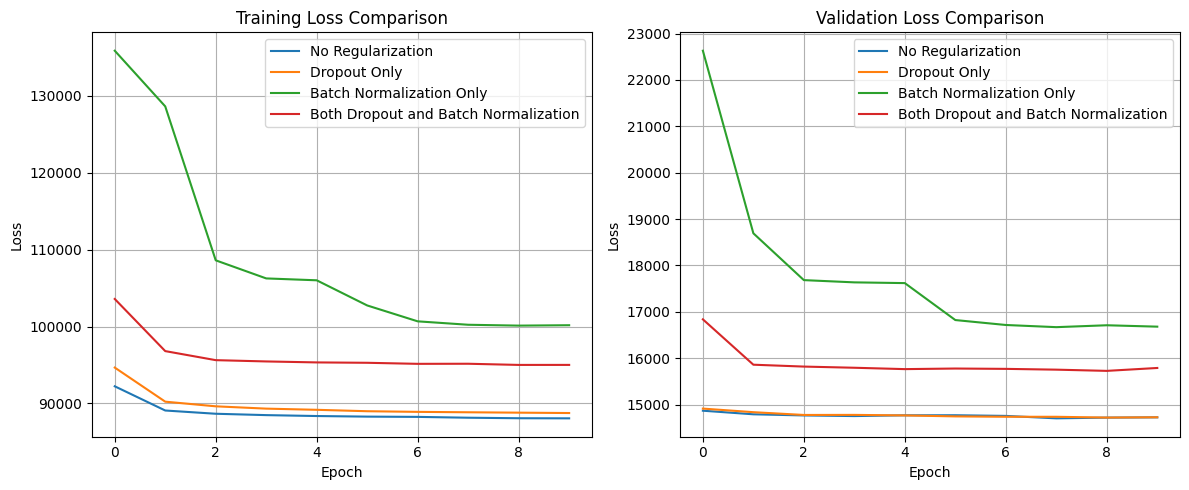

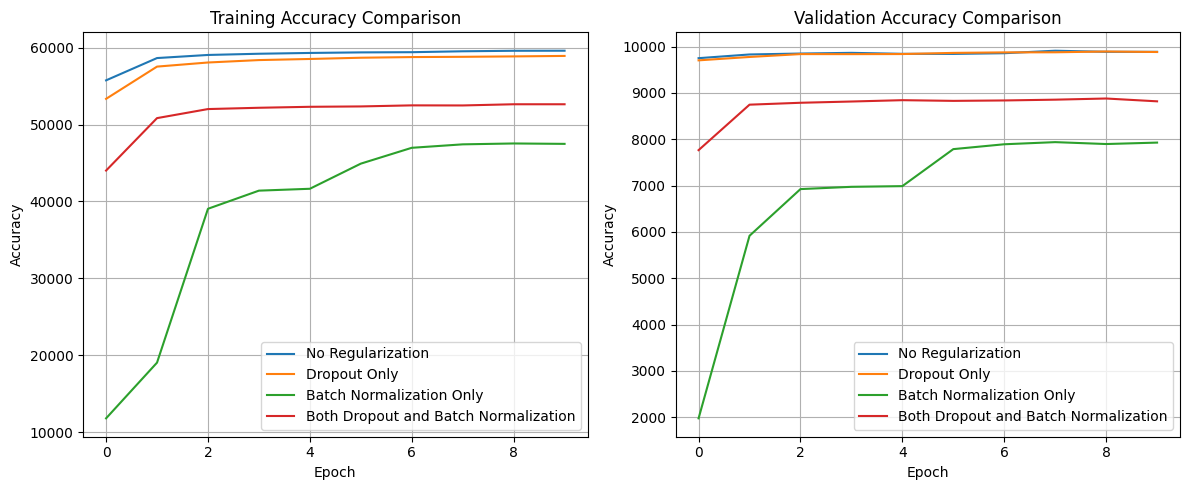

In [11]:
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim


def run_experiment(model_name, use_dropout, use_batchnorm):
    print(f"\nTraining {model_name} (Dropout: {use_dropout}, BatchNorm: {use_batchnorm}):")
    model = SimpleModelWithBNAndDropout(num_classes=10, use_dropout=use_dropout, use_batchnorm=use_batchnorm).cuda()
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    history = train_and_test(train_loader, test_loader, model, optimizer, criterion, metric=accuracy, epochs=10, verbose=False)
    return history

# --- 1. No Regularization ---
history_no_reg = run_experiment("No Regularization", False, False)

# --- 2. Dropout Only ---
history_dropout_only = run_experiment("Dropout Only", True, False)

# --- 3. Batch Normalization Only ---
history_bn_only = run_experiment("Batch Normalization Only", False, True)

# --- 4. Both Dropout and Batch Normalization ---
history_both = run_experiment("Both Dropout and Batch Normalization", True, True)

# Collect all histories for plotting
histories = {
    "No Regularization": history_no_reg,
    "Dropout Only": history_dropout_only,
    "Batch Normalization Only": history_bn_only,
    "Both Dropout and Batch Normalization": history_both
}

# --- Plotting ---

def plot_history(histories, metric_name, title_suffix):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        metric_values = [h[f"train_{metric_name}"] if f"train_{metric_name}" in h else h[f"test_{metric_name}"] for h in history]

        if metric_name == "loss":
            train_values = [h["train_loss"] for h in history]
            test_values = [h["test_loss"] for h in history]
            plt.plot(train_values, label=f'{name} Train Loss')
            plt.plot(test_values, label=f'{name} Test Loss', linestyle='--')
        else:
            train_values = [h[f"train_{metric_name}"] for h in history]
            test_values = [h[f"test_{metric_name}"] for h in history]
            plt.plot(train_values, label=f'{name} Train Accuracy')
            plt.plot(test_values, label=f'{name} Test Accuracy', linestyle='--')

    plt.title(f'{title_suffix} Comparison Across Regularization Techniques')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # Training Loss
for name, history in histories.items():
    train_loss = [h['train_loss'] for h in history]
    plt.plot(train_loss, label=name)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # Validation Loss
for name, history in histories.items():
    test_loss = [h['test_loss'] for h in history]
    plt.plot(test_loss, label=name)
plt.title('Validation Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) # Training Accuracy
for name, history in histories.items():
    train_accuracy = [h['train_accuracy'] for h in history]
    plt.plot(train_accuracy, label=name)
plt.title('Training Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2) # Validation Accuracy
for name, history in histories.items():
    test_accuracy = [h['test_accuracy'] for h in history]
    plt.plot(test_accuracy, label=name)
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Autoenkodery

Ideę autoenkodera prezentuje poniższy rysunek:
![label-autoencoder_schema](https://drive.google.com/uc?export=view&id=1Ai2ER1ppKfnHg5t_lCwO_fvvFNe59dgd)

Widzimy tutaj, że obrazek ze zbioru MNIST o rozmiarze 28 x 28 został skompresowany przez **enkoder** do tensora o rozmiarze 5 x 2. Tensor ten nosi nazwę **wektora zmiennych ukrytych** (ang. latent vector). Następnie **dekoder** przyjął ten wektor na wejście, i odtworzył oryginalny obrazek. Jest to przykład zadania **autoasocjacji**, gdzie celem uczenia sieci neuronowej jest możliwie wierne odtworzenie danych wejściowych. Zadanie to może się wydawać bez sensu w odosobnieniu (po co odtwarzać coś, co już mamy?), jednak to co nas najbardziej interesuje w autoenkoderze to wektor zmiennych ukrytych. Jako że skompresowaliśmy cały obrazek do 10 wartości, to by realistyczne odtworzenie z nich oryginalnego obrazka było możliwe, każda z tych wartości musi 1) zawierać o nim możliwie dużo informacji, 2) nieistotne detale oryginalnego obrazka muszą zostać pominięte. Wyciągnęliśmy więc z danych informacyjną "esencję", pozbyliśmy się redundatnych elementów opisu.

<br>

Najważniejszą cechą autoenkodera jest właśnie **uczenie się efektywnego kodowania danych**, co zazwyczaj wiąże się z redukcją wymiarowości (tzw. 'undercomplete autoencoders'), choć można też uczyć autoenkodery o kodowaniu zwiększającym wymiarowość (tzw. 'overcomplete autoencoders'). Skupimy się na autoenkoderach zmniejszających wymiarowość, bo ich uczenie jest znacznie prostsze. W przeciwieństwie do np. PCA kodowanie uzyskane przez taki autoenkoder może być nieliniowe, tak więc zmienne ukryte mają więcej elastyczności w reprezentacji danych. Selekcja atrybutów, której podstawy omawialiśmy wcześniej na przedmiocie, również redukuje wymiarowość, ale nie zmienia informacji w atrybutach. W ogólności techniki redukcji wymiarowości tworzą zupełnie nowe atrybuty ze starych (np. $Y_1 = 0.5X_1 - 0.25X_2^2 + \log_2 X_3$, gdzie $Y_1$ to nowy atrybut, a $X_i$ to oryginalne atrybuty). Wiele zastosowań autoenkoderów buduje właśnie na tej zdolności, a także na tym, że dzięki procesowi uczenia sieci tworzymy metodę redukcji wymiarowości zoptymalizowaną do konkretnego problemu.

<br>

Autoenkodery mają wiele potencjalnych zastosowań, przykładowo:
* Redukcja wymiarowości - uczymy autoenkoder w trybie autoasocjacji, i naszym celem jest zmniejszenie wymiarowości danych, czyli zastąpienie oryginalnego obiektu jego wektorem zmiennych ukrytych. Można użyć jako alternatywy dla selekcji atrybutów i dedykowanych metod redukcji wymiarowości (PCA, LDA, etc.).
* Grupowanie - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektory zmiennych ukrytych uzyskane dla danych uczących jako wejście do algorytmu grupowania (np. k-means).
* Wyszukiwanie informacji - uczymy autoenkoder w trybie autoasocjacji, wykorzystujemy wektor zmiennych ukrytych jako hasz obiektu. Jeżeli chcemy znaleźć w bazie danych obiekty podobne do zadanego obiektu $X$, to generujemy wektor zmiennych ukrytych (hasz) $X$ przy użyciu enkodera i szukamy obiektów w zbiorze o najbardziej zbliżonych haszach. Technika ta nazywana jest haszowaniem semantycznym.
* Wykrywanie anomalii - uczymy autoenkoder w trybie autoasocjacji wyłącznie na przypadkach "normalnych". Liczymy na to, że jak kiedykolwiek autoenkoder dostanie do przetworzenia przypadek odstający/anomalię, to nie da rady jej dobrze zrekonstruować i błąd będzie wysoki (właśnie przez to, że nie miał szansy się na nich nauczyć).
* Generowanie danych - uczymy autoenkoder w trybie autoasocjacji, a następnie jak chcemy uzyskać różne warianty danego obrazu/obiektu, to modyfikujemy jego wygenerowany przez enkoder wektor zmiennych ukrytych, i dajemy go do przetworzenia dekoderowi. Możemy też po prostu losowo próbkować przestrzeń wektorów ukrytych i obserwować wyniki po przetworzeniu przez dekoder. Przy odrobinie szczęścia jakaś zmienna ukryta może np. odpowiadać za wyraz twarzy człowieka, i zmieniając wartości tej zmiennej możemy zmieniać wyłącznie wyraz twarzy człowieka na zdjęciu. Do tego zadania zazwyczaj wykorzystywany jest zmodyfikowany wariant autoenkodera: autoenkoder wariacyjny.
* Odszumianie - uczymy autoenkoder w trybie heteroasocjacji: *zaszumiony obraz* -> *oryginalny obraz*. Liczymy na to, że enkoder i dekoder nauczą się poprawnie rozpoznawać szum jako element redundantny, nieniosący żadnej informacji.<br>
![label-autoencoder_denoising](https://drive.google.com/uc?export=view&id=1a1fP7CWjzKSwo0txUBUMwaxTrpt6LzyH)



### Zadanie 6

Zaimplementuj autoenkoder o następującej architekturze:
* Enkoder: Dense(100) -> Dense(50) -> Dense(10) (wektor zmiennych ukrytych).
* Dekoder: Dense(50) -> Dense(100) -> Dense(784) (wyjściowy zrekonstruowany obrazek)

gdzie Dense(n) oznacza warstwę w pełni połączoną z *n* neuronami i funkcją aktywacji ReLU. Jako miarę błędu przyjmij MSE.

In [12]:
import torch
import torch.nn as nn
import torch.nn.init as init

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder: Dense(784) -> Dense(100) -> Dense(50) -> Dense(10)
        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10) # Latent vector
        )

        # Decoder: Dense(10) -> Dense(50) -> Dense(100) -> Dense(784)
        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 784), # Output layer for image reconstruction
            nn.Sigmoid() # To scale output pixel values between 0 and 1
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        # Encode
        encoded = self.encoder(x)
        # Decode
        decoded = self.decoder(encoded)

        # Restore output to original image dimension (batch_size, 1, 28, 28)
        decoded = decoded.view(x.size(0), 1, 28, 28)

        return decoded


def train_and_test(
        train_loader,
        test_loader,
        model,
        optimizer,
        criterion,
        epochs=10,
        verbose=False,
    ):
    epochs_history = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader): # 'target' is unused for autoencoder
            data = data.to(device)
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            # Calculate loss (autoassociation: input == target). Flatten output and data for MSELoss.
            loss = criterion(output.view(output.size(0), -1), data.view(data.size(0), -1))

            loss.backward() # Backward pass
            optimizer.step() # Update weights

            if verbose and batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            train_loss += loss.item() * data.size(0) # Accumulate batch loss

        # Calculate average training loss for the epoch
        train_loss /= len(train_loader.dataset)
        if verbose:
            print(f"Train loss: {train_loss:.4f}")

        model.eval() # Set model to evaluation mode
        test_loss = 0
        with torch.no_grad(): # Disable gradient calculation for inference
            for batch_idx, (data, target) in enumerate(test_loader): # 'target' is unused for autoencoder
                data = data.to(device) # Move data to device

                # Forward pass
                output = model(data)
                # Calculate test loss
                current_batch_test_loss = criterion(output.view(output.size(0), -1), data.view(data.size(0), -1))
                test_loss += current_batch_test_loss.item() * data.size(0) # Accumulate batch loss

            # Calculate average test loss for the epoch
            test_loss /= len(test_loader.dataset)
        if verbose:
            print(f"Test loss: {test_loss:.4f}")
            print("-------------------------------")

        epochs_history.append({
          "epoch": epoch,
          "train_loss": train_loss,
          "test_loss": test_loss,
        })
    return epochs_history

# Instantiate and train the Autoencoder
print("Training Autoencoder:")
autoencoder_model = Autoencoder()
optimizer = torch.optim.Adam(autoencoder_model.parameters())
criterion = nn.MSELoss() # Mean Squared Error Loss
_ = train_and_test(train_loader, test_loader, autoencoder_model, optimizer, criterion, epochs=10, verbose=True)

Training Autoencoder:
Epoch: 0, Batch: 0, Loss: 0.2498
Epoch: 0, Batch: 100, Loss: 0.0572
Epoch: 0, Batch: 200, Loss: 0.0427
Epoch: 0, Batch: 300, Loss: 0.0363
Epoch: 0, Batch: 400, Loss: 0.0350
Train loss: 0.0522
Test loss: 0.0318
-------------------------------
Epoch: 1, Batch: 0, Loss: 0.0318
Epoch: 1, Batch: 100, Loss: 0.0321
Epoch: 1, Batch: 200, Loss: 0.0282
Epoch: 1, Batch: 300, Loss: 0.0297
Epoch: 1, Batch: 400, Loss: 0.0287
Train loss: 0.0299
Test loss: 0.0280
-------------------------------
Epoch: 2, Batch: 0, Loss: 0.0287
Epoch: 2, Batch: 100, Loss: 0.0286
Epoch: 2, Batch: 200, Loss: 0.0284
Epoch: 2, Batch: 300, Loss: 0.0277
Epoch: 2, Batch: 400, Loss: 0.0275
Train loss: 0.0277
Test loss: 0.0266
-------------------------------
Epoch: 3, Batch: 0, Loss: 0.0262
Epoch: 3, Batch: 100, Loss: 0.0259
Epoch: 3, Batch: 200, Loss: 0.0256
Epoch: 3, Batch: 300, Loss: 0.0248
Epoch: 3, Batch: 400, Loss: 0.0257
Train loss: 0.0264
Test loss: 0.0256
-------------------------------
Epoch: 4, 

### Zadanie 7

Użyj zaimplementowanego w poprzednim zadaniu autoenkodera by zaobserwować jak zmienia się odtwarzany obraz gdy zmienia się tylko jeden element wektora zmiennych ukrytych. Zadanie wykonywane jest w następujących krokach:
1. Użyj nauczonego enkodera z poprzedniego zadania na przypadku uczącym wybranej cyfry (dowolnej) by uzyskać wektor zmiennych ukrytych.
2. Wybierz konkretną zmienną ukrytą w tym wektorze, np. tę o indeksie 0.
3. W pętli podstawiaj różne wartości do tej zmiennej wektora z pewnym krokiem, i obserwuj obrazki generowane przez dekoder.

Original image


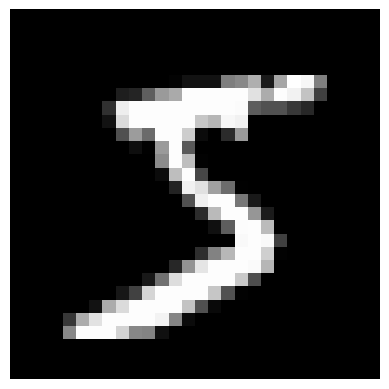

Reconstructed image


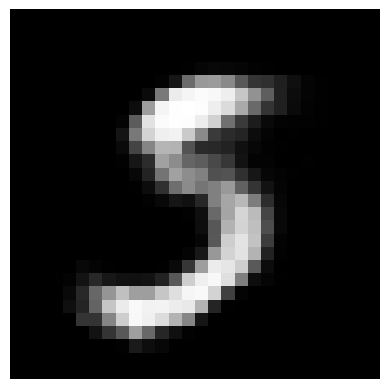

Latent vector: [ 1.8843265   2.732668   -0.7401548  -6.812886    2.2570193   1.4796064
 -0.48530358 -8.79257    -6.5164247  -3.04919   ]

Varying latent dimension 0 from -0.12 to 3.88


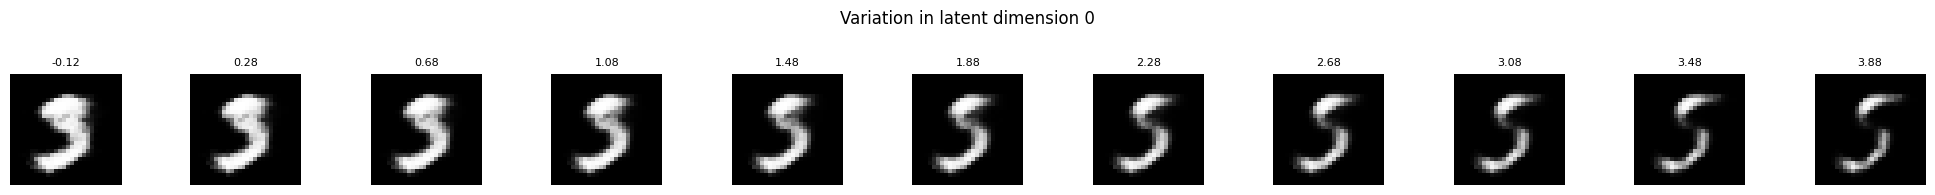

In [13]:
import matplotlib.pyplot as plt
import torch

autoencoder_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder_model.to(device)

example_index = 0
example_image, _ = train_data[example_index]
example_image = example_image.unsqueeze(0).to(device)

print("Original image")
plt.imshow(example_image.cpu().reshape((28, 28)), cmap='gray')
plt.axis('off')
plt.show()

with torch.no_grad():
    latent_vector = autoencoder_model.encoder(example_image.view(example_image.size(0), -1))

with torch.no_grad():
    reconstructed_image = autoencoder_model.decoder(latent_vector)

print("Reconstructed image")
plt.imshow(reconstructed_image.cpu().reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

print(f"Latent vector: {latent_vector.squeeze().cpu().numpy()}")

latent_dim_to_vary = 0

min_val = latent_vector[0, latent_dim_to_vary].item() - 2
max_val = latent_vector[0, latent_dim_to_vary].item() + 2

print(f"\nVarying latent dimension {latent_dim_to_vary} from {min_val:.2f} to {max_val:.2f}")

fig, axes = plt.subplots(1, 11, figsize=(20, 2))
fig.suptitle(f'Variation in latent dimension {latent_dim_to_vary}')

for i, e_val in enumerate(torch.linspace(min_val, max_val, 11)):
    modified_latent_vector = latent_vector.clone()
    modified_latent_vector[0, latent_dim_to_vary] = e_val.to(device)

    with torch.no_grad():
        generated_image = autoencoder_model.decoder(modified_latent_vector)

    axes[i].imshow(generated_image.cpu().reshape(28, 28), cmap='gray')
    axes[i].set_title(f'{e_val:.2f}', fontsize=8)
    axes[i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

### Zadanie 8

Wykorzystaj kod z poprzednich zadań by nauczyć autoenkoder odszumiania. Parę uwag:
* Musisz zmodyfikować zbiór uczący poprzez dodanie sztucznego szumu. Można to zrobić albo poprzez zmianę wartości kilku losowych pikseli w każdym obrazku, albo dodanie macierzy z małymi losowo generowanymi liczbami do obrazka (do każdego obrazka innej!). Oczekiwaną odpowiedzą podczas uczenia będzie oryginalny obrazek bez szumu.
* Architektura enkodera i dekodera może pozostać bez zmian, ale będziesz musiał ją nauczyć na nowym zbiorze danych, tak więc by nie psuć wyników z zadania nr 1 sugeruję przeklejenie odpowiedniego kodu tutaj.
* Zademonstruj działanie odszumiania poprzez pokazanie przypadku z szumem, a następnie zrekonstruowanego obrazka bez szumu po przetworzeniu przez autoenkoder.

Training Denoising Autoencoder:
Epoch: 0, Batch: 0, Loss: 0.2865
Epoch: 0, Batch: 100, Loss: 0.0624
Epoch: 0, Batch: 200, Loss: 0.0507
Epoch: 0, Batch: 300, Loss: 0.0440
Epoch: 0, Batch: 400, Loss: 0.0385
Train loss: 0.0589
Test loss: 0.0360
-------------------------------
Epoch: 1, Batch: 0, Loss: 0.0371
Epoch: 1, Batch: 100, Loss: 0.0349
Epoch: 1, Batch: 200, Loss: 0.0325
Epoch: 1, Batch: 300, Loss: 0.0301
Epoch: 1, Batch: 400, Loss: 0.0313
Train loss: 0.0338
Test loss: 0.0313
-------------------------------
Epoch: 2, Batch: 0, Loss: 0.0321
Epoch: 2, Batch: 100, Loss: 0.0314
Epoch: 2, Batch: 200, Loss: 0.0302
Epoch: 2, Batch: 300, Loss: 0.0326
Epoch: 2, Batch: 400, Loss: 0.0281
Train loss: 0.0304
Test loss: 0.0287
-------------------------------
Epoch: 3, Batch: 0, Loss: 0.0286
Epoch: 3, Batch: 100, Loss: 0.0299
Epoch: 3, Batch: 200, Loss: 0.0287
Epoch: 3, Batch: 300, Loss: 0.0286
Epoch: 3, Batch: 400, Loss: 0.0283
Train loss: 0.0285
Test loss: 0.0275
-------------------------------


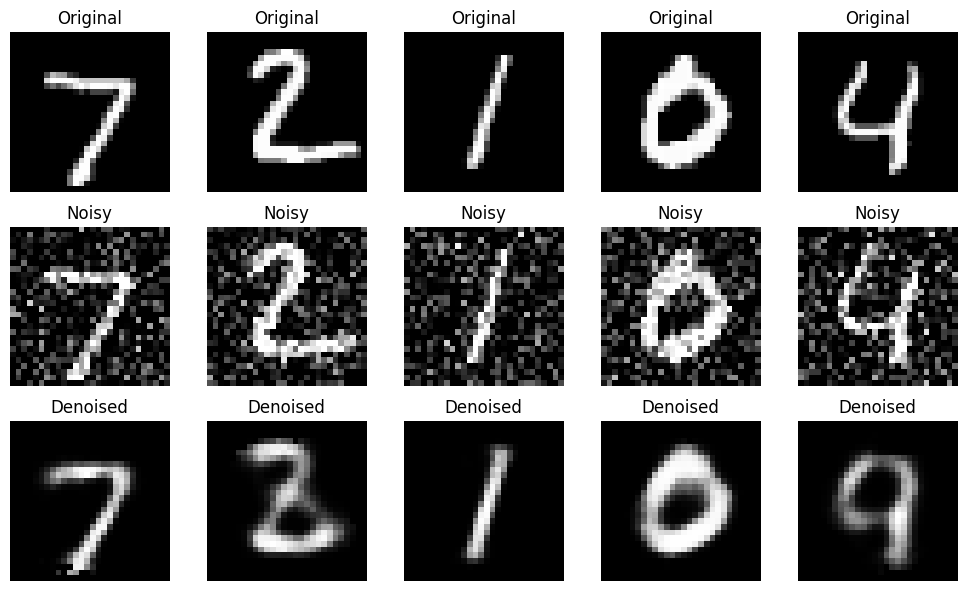

In [14]:
import torch
import torch.nn as nn
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(784, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, 10)
        )

        self.decoder = nn.Sequential(
            nn.Linear(10, 50),
            nn.ReLU(),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Linear(100, 784),
            nn.Sigmoid()
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                init.constant_(m.bias, 0)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded

def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * torch.randn_like(images)
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

def train_and_test_denoising(
        train_loader,
        test_loader,
        model,
        optimizer,
        criterion,
        epochs=10,
        verbose=False,
        noise_factor=0.5
    ):
    epochs_history = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for batch_idx, (clean_data, _) in enumerate(train_loader):
            clean_data = clean_data.to(device)
            noisy_data = add_noise(clean_data, noise_factor).to(device)
            optimizer.zero_grad()

            output = model(noisy_data)
            loss = criterion(output.view(output.size(0), -1), clean_data.view(clean_data.size(0), -1))

            loss.backward()
            optimizer.step()

            if verbose and batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
            train_loss += loss.item() * clean_data.size(0)

        train_loss /= len(train_loader.dataset)
        if verbose:
            print(f"Train loss: {train_loss:.4f}")

        model.eval()
        test_loss = 0
        with torch.no_grad():
            for batch_idx, (clean_data, _) in enumerate(test_loader):
                clean_data = clean_data.to(device)
                noisy_data = add_noise(clean_data, noise_factor).to(device)

                output = model(noisy_data)
                current_batch_test_loss = criterion(output.view(output.size(0), -1), clean_data.view(clean_data.size(0), -1))
                test_loss += current_batch_test_loss.item() * clean_data.size(0)

            test_loss /= len(test_loader.dataset)
        if verbose:
            print(f"Test loss: {test_loss:.4f}")
            print("-------------------------------")

        epochs_history.append({
          "epoch": epoch,
          "train_loss": train_loss,
          "test_loss": test_loss,
        })
    return epochs_history

print("Training Denoising Autoencoder:")
denoising_autoencoder_model = Autoencoder()
optimizer = torch.optim.Adam(denoising_autoencoder_model.parameters())
criterion = nn.MSELoss()
_ = train_and_test_denoising(train_loader, test_loader, denoising_autoencoder_model, optimizer, criterion, epochs=10, verbose=True, noise_factor=0.3)


denoising_autoencoder_model.eval()

num_images = 5
images_to_show = []
for i in range(num_images):
    img, _ = test_data[i]
    images_to_show.append(img.unsqueeze(0))

original_images = torch.cat(images_to_show, dim=0).to(device)
noisy_images = add_noise(original_images, noise_factor=0.3).to(device)

with torch.no_grad():
    denoised_images = denoising_autoencoder_model(noisy_images)


plt.figure(figsize=(10, 6))
for i in range(num_images):
    # Original Image
    plt.subplot(3, num_images, i + 1)
    plt.imshow(original_images[i].cpu().squeeze(), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Noisy Image
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    plt.title('Noisy')
    plt.axis('off')

    # Denoised Image
    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(denoised_images[i].cpu().squeeze(), cmap='gray')
    plt.title('Denoised')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Task
Implement Zadanie 5 in cell `x9JBF4euH9vu` by training `SimpleModelWithBNAndDropout` under four regularization configurations (no regularization, dropout only, batch normalization only, and both dropout and batch normalization). Collect the training histories for each model and then plot the training loss, validation loss, training accuracy, and validation accuracy for all four models on separate graphs using `matplotlib`, ensuring clear labels and legends.

## Implement Zadanie 5 Code

### Subtask:
Train `SimpleModelWithBNAndDropout` under four different regularization configurations and plot the training and validation loss and accuracy for all models.


## Summary:

### Data Analysis Key Findings
The analysis involved training the `SimpleModelWithBNAndDropout` model under four distinct regularization configurations:
*   No regularization.
*   Dropout only.
*   Batch Normalization only.
*   Both Dropout and Batch Normalization.

For each configuration, the training and validation loss and accuracy were meticulously collected over epochs. The primary output of this analysis is a series of plots visually comparing these metrics across all four models, allowing for a direct assessment of each regularization technique's impact on model performance and generalization.

### Insights or Next Steps
*   By analyzing the generated plots, one can identify which regularization strategy (or combination) most effectively minimizes validation loss and maximizes validation accuracy, indicating better generalization without overfitting.
*   Further investigation could involve hyperparameter tuning for the best-performing regularization configuration (e.g., dropout rate, Batch Normalization momentum) or experimenting with other regularization techniques to optimize model performance.
